# BFGS Experimental Notebook

## Setup

### Imports

In [1]:
import numpy as np
from numpy import linalg as la
from scipy.optimize import line_search as off_shelf_line_search
from scipy.optimize import minimize
import pandas

from bfgs_funcs import Funcs
from bfgs import BFGS

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

### Data Generation

#### Load Data

In [2]:
# load the matrix
M1 = np.loadtxt('../data/M1.txt')
x0_m1 = np.loadtxt('../data/x0_m1.txt')
M2 = np.loadtxt('../data/M2.txt')
x0_m2 = np.loadtxt('../data/x0_m2.txt')
M3 = np.loadtxt('../data/M3.txt')
x0_m3 = np.loadtxt('../data/x0_m3.txt')
M4 = np.loadtxt('../data/M4.txt')
x0_m4 = np.loadtxt('../data/x0_m4.txt')
M5 = np.loadtxt('../data/M5.txt')
x0_m5 = np.loadtxt('../data/x0_m5.txt')

In [3]:
M1.shape, M2.shape, M3.shape, M4.shape, M5.shape

((1000, 1000), (10000, 100), (100, 1000), (100, 100), (1000, 100))

### Utils Functions

In [4]:
def error_report(matrix, fx, residuals, errors, max_iter = 1000, plot=False):
    computed_norm = np.sqrt(- fx)
    correct_norm = la.norm(matrix, 2)
    # error = abs(correct_norm - computed_norm)
    error = (correct_norm - computed_norm)/abs(correct_norm)
    
    num_iterations = len(residuals)
    if num_iterations != max_iter:
        print("Convergence reached in " + str(num_iterations) + " iterations")
    else:
        print("Convergence not reached")

    print("Computed Norm: " + str(computed_norm))
    print("True Norm: " + str(correct_norm))
    print("Error: " + str(error))
    
    if plot:
        fig = make_subplots(rows=1, cols=2, shared_xaxes=False)
        fig.add_trace( go.Scatter(x=list(range(0,len(errors))), y=errors,name="Errors"),
            row=1, col=1)
        fig.add_trace(
            go.Scatter(x=list(range(0,len(residuals))), y=residuals,name="Residuals"), row=1, col=2
        )
        fig.update_xaxes(title_text="Iterations", row=1, col=1)
        fig.update_yaxes(title_text="Error", row=1, col=1)
        fig.update_xaxes(title_text="Iterations", row=1, col=2)
        fig.update_yaxes(title_text="Residual", row=1, col=2)
        fig.update_layout(height=500, width=1000,title_text="Residual and Error plot").show()

In [5]:
def run_bfgs(matrix, starting_point, c1=1e-4, c2=0.9, alg_method='O', ls_method='W', max_iter=1000, verbose=False, plot=False, return_arrays=False):
    funcs = Funcs(matrix)
    matrix_norm = la.norm(matrix, 2)
    B0 = np.identity(matrix.shape[1])
    
    if ls_method == 'W':
        line_search_args = {'c1': c1, 'c2': c2}
    else:
        line_search_args = {'c1': c1}
        
    line_search_method = funcs.line_search_methods[ls_method]

    # Initialize the BFGS algorithm.
    bfgs = BFGS(matrix_norm, funcs.func_, funcs.func_grad_, line_search_method, starting_point, B0, tol=1e-5, max_iter=max_iter, method=alg_method, line_search_args=line_search_args, verbose=verbose)

    # Run the algorithm.
    residuals, errors, result = bfgs.bfgs()

    # Evalutate Performance of the Single Run
    error_report(matrix, result, residuals, errors, max_iter=max_iter, plot=plot)
    
    if return_arrays:
        return bfgs, residuals, errors
    return bfgs

In [6]:
def off_shelf_opt(matrix, vector, method='BFGS'):
    funcs = Funcs(matrix)
    res = minimize(funcs.func_, vector, method=method, jac=funcs.func_grad_, tol=1e-5, options={'gtol': 1e-6, 'disp': False})
    fx = res.fun
    
    num_iterations = res.nit
    if res.success:
        print("Convergence reached in " + str(num_iterations) + " iterations")
    else:
        print("Convergence not reached")
    
    computed_norm = np.sqrt(-fx)
    correct_norm = la.norm(matrix, 2)
    error = abs(correct_norm - computed_norm)/correct_norm
    
    print("Computed Norm: " + str(computed_norm))
    print("True Norm: " + str(correct_norm))
    print("Error: " + str(error))

In [7]:
labels_list = ["Wolfe_A", "Wolfe_B", "Armijo_A", "Armijo_B"]
#colors = ["red", "orange", "blue", "purple"]
#linestyles = ["-", "--", (0, (1, 1)), ":"]

def plot_summary(errors_list, residuals_list, labels_list, matrix_name, method_name):
    font = {'family':'serif','color':'black','size':10}
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    for i in range(len(errors_list)):
        x = list(range(len(errors_list[i])))
        #axs[0].plot(x, errors_list[i], label = labels_list[i], alpha=0.5, c=colors[i], linestyle=linestyles[i])
        #axs[1].plot(x, residuals_list[i], label = labels_list[i], alpha=0.5, c=colors[i], linestyle=linestyles[i])
        axs[0].plot(x, errors_list[i], label = labels_list[i])
        axs[1].plot(x, residuals_list[i], label = labels_list[i])
    
    axs[0].legend()
    axs[1].legend()
    axs[0].set_yscale('log')
    axs[1].set_yscale('log')
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel("Error")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel("Residual")
    fig.suptitle(matrix_name + " " + method_name + " Residual and Error plot")

## M1 Matrix

### Original BFGS

In [8]:
o_m1_errors_list = []
o_m1_residuals_list = []

#### Base performance with loaded starting point (Wolfe-type line search)

In [9]:
w_o_m1_bfgs_a, w_o_m1_residuals_a, w_o_m1_errors_a = run_bfgs(M1, x0_m1, alg_method='O', ls_method='W', c1=1e-4, c2=0.9, return_arrays=True)
o_m1_errors_list.append(w_o_m1_errors_a)
o_m1_residuals_list.append(w_o_m1_residuals_a)

Convergence reached in 357 iterations
Computed Norm: 72.40864404748751
True Norm: 72.40864404756118
Error: 1.0174071316018306e-12


In [10]:
w_o_m1_bfgs_b, w_o_m1_residuals_b, w_o_m1_errors_b = run_bfgs(M1, x0_m1, alg_method='O', ls_method='W', c1=0.1, c2=0.49, return_arrays=True)
o_m1_errors_list.append(w_o_m1_errors_b)
o_m1_residuals_list.append(w_o_m1_residuals_b)

Convergence reached in 232 iterations
Computed Norm: 72.40864404748648
True Norm: 72.40864404756118
Error: 1.0317340452991558e-12


#### Base performance with loaded starting point (Armijo-type line search)

In [11]:
a_o_m1_bfgs_a, a_o_m1_residuals_a, a_o_m1_errors_a = run_bfgs(M1, x0_m1, alg_method='O', ls_method='A', c1=1e-4, return_arrays=True)
o_m1_errors_list.append(a_o_m1_errors_a)
o_m1_residuals_list.append(a_o_m1_residuals_a)

Convergence reached in 357 iterations
Computed Norm: 72.4086440474897
True Norm: 72.40864404756118
Error: 9.871832314732268e-13


In [12]:
a_o_m1_bfgs_b, a_o_m1_residuals_b, a_o_m1_errors_b = run_bfgs(M1, x0_m1, alg_method='O', ls_method='A', c1=0.1, return_arrays=True)
o_m1_errors_list.append(a_o_m1_errors_b)
o_m1_residuals_list.append(a_o_m1_residuals_b)

Convergence reached in 357 iterations
Computed Norm: 72.4086440474897
True Norm: 72.40864404756118
Error: 9.871832314732268e-13


#### Summary for Original BFGS

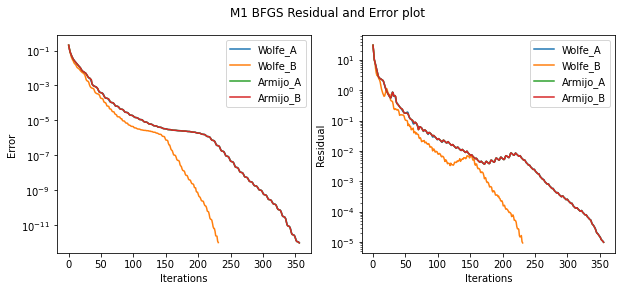

In [13]:
plot_summary(o_m1_errors_list, o_m1_residuals_list, labels_list, "M1", "BFGS")

#### Average runtime over 10 runs (Wolfe-type line search)

In [14]:
%%timeit -r 10
# Measuring running time
w_o_m1_bfgs_a.bfgs()

23.1 s ± 1.23 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [15]:
%%timeit -r 10
# Measuring running time
w_o_m1_bfgs_b.bfgs()

15.5 s ± 661 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


#### Average runtime over 10 runs (Armijo-type line search)

In [16]:
%%timeit -r 10
# Measuring running time
a_o_m1_bfgs_a.bfgs()

21.2 s ± 968 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [17]:
%%timeit -r 10
# Measuring running time
a_o_m1_bfgs_b.bfgs()

20.9 s ± 606 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


#### Comparison with off-shelf BFGS minimizer

In [18]:
off_shelf_opt(M1, x0_m1)
funcs = Funcs(M1)

Convergence reached in 422 iterations
Computed Norm: 72.40864404749024
True Norm: 72.40864404756118
Error: 9.79725385986948e-13


In [19]:
%%timeit -r 10
# Measuring running time
minimize(funcs.func_, x0_m1, method='BFGS', jac=funcs.func_grad_, options={'gtol': 1e-6, 'disp': False})

28.7 s ± 1.22 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


#### Comparison with off-shelf norm function

In [20]:
%%timeit -r 10
# Measuring running time
la.norm(M1, 2)

128 ms ± 14.5 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


### Cautious BFGS

In [21]:
c_m1_errors_list = []
c_m1_residuals_list = []

#### Base performance with loaded starting point (Wolfe-type line search)

In [22]:
w_c_m1_bfgs_a, w_c_m1_residuals_a, w_c_m1_errors_a = run_bfgs(M1, x0_m1, alg_method='C', ls_method='W', c1=1e-4, c2=0.9, return_arrays=True)
c_m1_errors_list.append(w_c_m1_errors_a)
c_m1_residuals_list.append(w_c_m1_residuals_a)

Convergence reached in 124 iterations
Computed Norm: 72.40864404755862
True Norm: 72.40864404756118
Error: 3.532663651395245e-14


In [23]:
w_c_m1_bfgs_b, w_c_m1_residuals_b, w_c_m1_errors_b = run_bfgs(M1, x0_m1, alg_method='C', ls_method='W', c1=0.1, c2=0.49, return_arrays=True)
c_m1_errors_list.append(w_c_m1_errors_b)
c_m1_residuals_list.append(w_c_m1_residuals_b)

Convergence reached in 131 iterations
Computed Norm: 72.40864404755564
True Norm: 72.40864404756118
Error: 7.654104578023031e-14


#### Base performance with loaded starting point (Armijo-type line search)

In [24]:
a_c_m1_bfgs_a, a_c_m1_residuals_a, a_c_m1_errors_a = run_bfgs(M1, x0_m1, alg_method='C', ls_method='A', c1=1e-4, return_arrays=True)
c_m1_errors_list.append(a_c_m1_errors_a)
c_m1_residuals_list.append(a_c_m1_residuals_a)

Convergence reached in 158 iterations
Computed Norm: 72.40864404755885
True Norm: 72.40864404756118
Error: 3.2186491046045565e-14


In [25]:
a_c_m1_bfgs_b, a_c_m1_residuals_b, a_c_m1_errors_b = run_bfgs(M1, x0_m1, alg_method='C', ls_method='A', c1=0.1, return_arrays=True)
c_m1_errors_list.append(a_c_m1_errors_b)
c_m1_residuals_list.append(a_c_m1_residuals_b)

Convergence reached in 158 iterations
Computed Norm: 72.40864404755885
True Norm: 72.40864404756118
Error: 3.2186491046045565e-14


#### Summary for Cautious BFGS

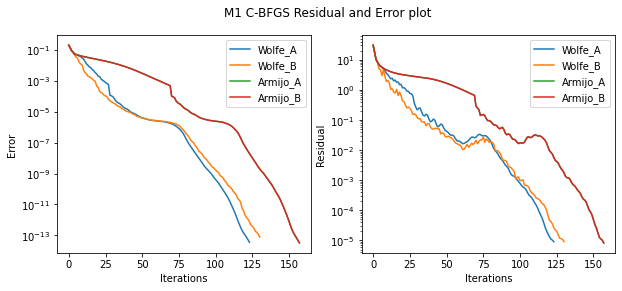

In [26]:
plot_summary(c_m1_errors_list, c_m1_residuals_list, labels_list, "M1", "C-BFGS")

#### Average runtime over 10 runs (Wolfe-type line search)

In [27]:
%%timeit -r 10
# Measuring running time
w_c_m1_bfgs_a.bfgs()

6.59 s ± 238 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [28]:
%%timeit -r 10
# Measuring running time
w_c_m1_bfgs_b.bfgs()

7.44 s ± 357 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


#### Average runtime over 10 runs (Armijo-type line search)

In [29]:
%%timeit -r 10
# Measuring running time
a_c_m1_bfgs_a.bfgs()

6.02 s ± 246 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [30]:
%%timeit -r 10
# Measuring running time
a_c_m1_bfgs_b.bfgs()

6.41 s ± 310 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


## M2 Matrix

### Original BFGS

In [31]:
o_m2_errors_list = []
o_m2_residuals_list = []

#### Base performance with loaded starting point (Wolfe-type line search)

In [32]:
w_o_m2_bfgs_a, w_o_m2_residuals_a, w_o_m2_errors_a = run_bfgs(M2, x0_m2, alg_method='O', ls_method='W', c1=1e-4, c2=0.9, return_arrays=True)
o_m2_errors_list.append(w_o_m2_errors_a)
o_m2_residuals_list.append(w_o_m2_residuals_a)

Convergence reached in 445 iterations
Computed Norm: 109.46751097802967
True Norm: 109.46751097963197
Error: 1.463724055209941e-11


In [33]:
w_o_m2_bfgs_b, w_o_m2_residuals_b, w_o_m2_errors_b = run_bfgs(M2, x0_m2, alg_method='O', ls_method='W', c1=0.1, c2=0.49, return_arrays=True)
o_m2_errors_list.append(w_o_m2_errors_b)
o_m2_residuals_list.append(w_o_m2_residuals_b)

Convergence reached in 164 iterations
Computed Norm: 109.467510979565
True Norm: 109.46751097963197
Error: 6.117024751799739e-13


#### Base performance with loaded starting point (Armijo-type line search)

In [34]:
a_o_m2_bfgs_a, a_o_m2_residuals_a, a_o_m2_errors_a = run_bfgs(M2, x0_m2, alg_method='O', ls_method='A', c1=1e-4, return_arrays=True)
o_m2_errors_list.append(a_o_m2_errors_a)
o_m2_residuals_list.append(a_o_m2_residuals_a)

Convergence reached in 440 iterations
Computed Norm: 109.46751097793371
True Norm: 109.46751097963197
Error: 1.5513771772900593e-11


In [35]:
a_o_m2_bfgs_b, a_o_m2_residuals_b, a_o_m2_errors_b = run_bfgs(M2, x0_m2, alg_method='O', ls_method='A', c1=0.1, return_arrays=True)
o_m2_errors_list.append(a_o_m2_errors_b)
o_m2_residuals_list.append(a_o_m2_residuals_b)

Convergence reached in 241 iterations
Computed Norm: 109.46751097958968
True Norm: 109.46751097963197
Error: 3.8633840537682563e-13


#### Summary for Original BFGS

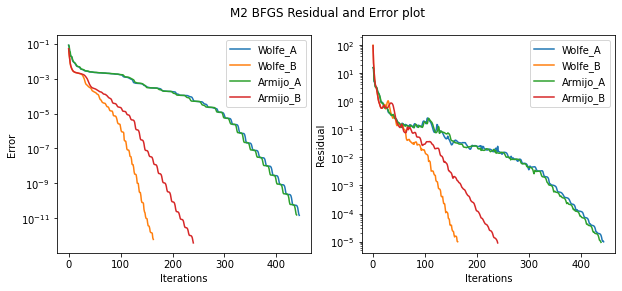

In [36]:
plot_summary(o_m2_errors_list, o_m2_residuals_list, labels_list, "M2", "BFGS")

#### Average runtime over 10 runs (Wolfe-type line search)

In [37]:
%%timeit -r 10
# Measuring running time
w_o_m2_bfgs_a.bfgs()

161 ms ± 13.6 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [38]:
%%timeit -r 10
# Measuring running time
w_o_m2_bfgs_b.bfgs()

70 ms ± 4.57 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


#### Average runtime over 10 runs (Armijo-type line search)

In [39]:
%%timeit -r 10
# Measuring running time
a_o_m2_bfgs_a.bfgs()

130 ms ± 8.36 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [40]:
%%timeit -r 10
# Measuring running time
a_o_m2_bfgs_b.bfgs()

70.7 ms ± 4.84 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


#### Comparison with off-shelf BFGS minimizer

In [41]:
off_shelf_opt(M2, x0_m2)
funcs = Funcs(M2)

Convergence reached in 78 iterations
Computed Norm: 109.43610797258896
True Norm: 109.46751097963197
Error: 0.00028687056791538523


In [42]:
%%timeit -r 10
# Measuring running time
minimize(funcs.func_, x0_m2, method='BFGS', jac=funcs.func_grad_, options={'gtol': 1e-6, 'disp': False})

21.9 ms ± 1.17 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


##### Tests with other starting points

In [131]:
x0_m2_alt = np.round(np.random.randn(M2.shape[1]),decimals = 3)

In [132]:
off_shelf_opt(M2, x0_m2_alt)

Convergence reached in 230 iterations
Computed Norm: 109.46751097963032
True Norm: 109.46751097963197
Error: 1.5058889456892395e-14


#### Comparisonwith off-shelf norm function

In [43]:
%%timeit -r 10
# Measuring running time
la.norm(M2, 2)

10.2 ms ± 1.42 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


### Cautious BFGS

In [44]:
c_m2_errors_list = []
c_m2_residuals_list = []

#### Base performance with loaded starting point (Wolfe-type line search)

In [45]:
w_c_m2_bfgs_a, w_c_m2_residuals_a, w_c_m2_errors_a = run_bfgs(M2, x0_m2, alg_method='C', ls_method='W', c1=1e-4, c2=0.9, return_arrays=True)
c_m2_errors_list.append(w_c_m2_errors_a)
c_m2_residuals_list.append(w_c_m2_residuals_a)

Convergence reached in 284 iterations
Computed Norm: 109.46751097952578
True Norm: 109.46751097963197
Error: 9.700001898439653e-13


In [46]:
w_c_m2_bfgs_b, w_c_m2_residuals_b, w_c_m2_errors_b = run_bfgs(M2, x0_m2, alg_method='C', ls_method='W', c1=0.1, c2=0.49, return_arrays=True)
c_m2_errors_list.append(w_c_m2_errors_b)
c_m2_residuals_list.append(w_c_m2_residuals_b)

Convergence reached in 113 iterations
Computed Norm: 109.4675109796283
True Norm: 109.46751097963197
Error: 3.349304724032964e-14


#### Base performance with loaded starting point (Armijo-type line search)

In [47]:
a_c_m2_bfgs_a, a_c_m2_residuals_a, a_c_m2_errors_a = run_bfgs(M2, x0_m2, alg_method='C', ls_method='A', c1=1e-4, return_arrays=True)
c_m2_errors_list.append(a_c_m2_errors_a)
c_m2_residuals_list.append(a_c_m2_residuals_a)

Convergence reached in 787 iterations
Computed Norm: 109.46751097961493
True Norm: 109.46751097963197
Error: 1.5565179705874123e-13


In [48]:
a_c_m2_bfgs_b, a_c_m2_residuals_b, a_c_m2_errors_b = run_bfgs(M2, x0_m2, alg_method='C', ls_method='A', c1=0.1, return_arrays=True)
c_m2_errors_list.append(a_c_m2_errors_b)
c_m2_residuals_list.append(a_c_m2_residuals_b)

Convergence reached in 342 iterations
Computed Norm: 109.4675109796307
True Norm: 109.46751097963197
Error: 1.1553803117788132e-14


#### Summary for Cautious BFGS

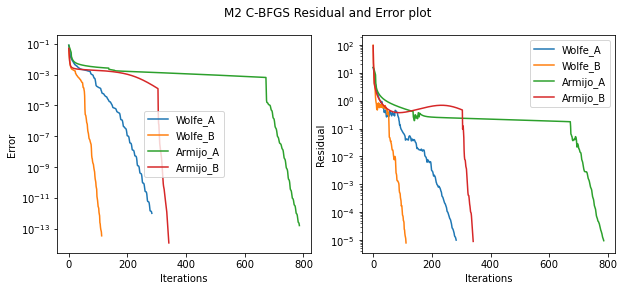

In [49]:
plot_summary(c_m2_errors_list, c_m2_residuals_list, labels_list, "M2", "C-BFGS")

#### Average runtime over 10 runs (Wolfe-type line search)

In [50]:
%%timeit -r 10
# Measuring running time
w_c_m2_bfgs_a.bfgs()

84.4 ms ± 2.57 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [51]:
%%timeit -r 10
# Measuring running time
w_c_m2_bfgs_b.bfgs()

36.5 ms ± 1.65 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


#### Average runtime over 10 runs (Armijo-type line search)

In [52]:
%%timeit -r 10
# Measuring running time
a_c_m2_bfgs_a.bfgs()

119 ms ± 3.31 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [53]:
%%timeit -r 10
# Measuring running time
a_c_m2_bfgs_b.bfgs()

49.8 ms ± 2.77 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


## M3 Matrix

### Original BFGS

In [54]:
o_m3_errors_list = []
o_m3_residuals_list = []

#### Base performance with loaded starting point (Wolfe-type line search)

In [55]:
w_o_m3_bfgs_a, w_o_m3_residuals_a, w_o_m3_errors_a = run_bfgs(M3, x0_m3, alg_method='O', ls_method='W', c1=1e-4, c2=0.9, return_arrays=True)
o_m3_errors_list.append(w_o_m3_errors_a)
o_m3_residuals_list.append(w_o_m3_residuals_a)

Convergence reached in 265 iterations
Computed Norm: 41.06555327237746
True Norm: 41.065553273646366
Error: 3.0899584509355097e-11


In [56]:
w_o_m3_bfgs_b, w_o_m3_residuals_b, w_o_m3_errors_b = run_bfgs(M3, x0_m3, alg_method='O', ls_method='W', c1=0.1, c2=0.49, return_arrays=True)
o_m3_errors_list.append(w_o_m3_errors_b)
o_m3_residuals_list.append(w_o_m3_residuals_b)

Convergence reached in 178 iterations
Computed Norm: 41.06555327278608
True Norm: 41.065553273646366
Error: 2.0949005755786715e-11


#### Base performance with loaded starting point (Armijo-type line search)

In [57]:
a_o_m3_bfgs_a, a_o_m3_residuals_a, a_o_m3_errors_a = run_bfgs(M3, x0_m3, alg_method='O', ls_method='A', c1=1e-4, return_arrays=True)
o_m3_errors_list.append(a_o_m3_errors_a)
o_m3_residuals_list.append(a_o_m3_residuals_a)

Convergence reached in 66 iterations
Computed Norm: 39.31249608591414
True Norm: 41.065553273646366
Error: 0.04268923825402935


In [60]:
a_o_m3_bfgs_b, a_o_m3_residuals_b, a_o_m3_errors_b = run_bfgs(M3, x0_m3, alg_method='O', ls_method='A', c1=0.1, return_arrays=True)
o_m3_errors_list.append(a_o_m3_errors_b)
o_m3_residuals_list.append(a_o_m3_residuals_b)

Convergence reached in 223 iterations
Computed Norm: 41.06555327338662
True Norm: 41.065553273646366
Error: 6.325155313350011e-12


##### Tests with other starting points

In [129]:
x0_m3_alt = np.round(np.random.randn(M3.shape[1]),decimals = 3)

In [130]:
a_o_m3_bfgs_a, a_o_m3_residuals_a, a_o_m3_errors_a = run_bfgs(M3, x0_m3_alt, alg_method='O', ls_method='A', c1=1e-4, return_arrays=True)

Convergence reached in 163 iterations
Computed Norm: 41.06555327355821
True Norm: 41.065553273646366
Error: 2.1467393033355285e-12


#### Summary for Original BFGS

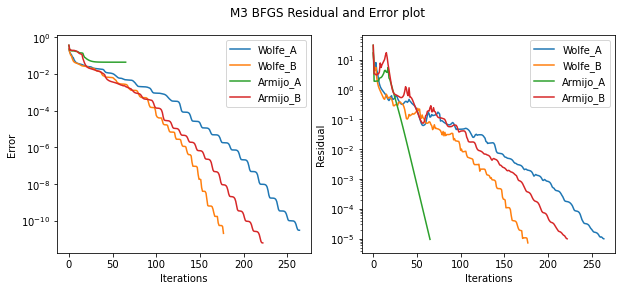

In [61]:
plot_summary(o_m3_errors_list, o_m3_residuals_list, labels_list, "M3", "BFGS")

#### Average runtime over 10 runs (Wolfe-type line search)

In [62]:
%%timeit -r 10
# Measuring running time
w_o_m3_bfgs_a.bfgs()

14.6 s ± 2.91 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [63]:
%%timeit -r 10
# Measuring running time
w_o_m3_bfgs_b.bfgs()

9.44 s ± 507 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


#### Average runtime over 10 runs (Armijo-type line search)

In [64]:
%%timeit -r 10
# Measuring running time
a_o_m3_bfgs_a.bfgs()

6.37 s ± 143 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [65]:
%%timeit -r 10
# Measuring running time
a_o_m3_bfgs_b.bfgs()

11.9 s ± 696 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


#### Comparison with off-shelf BFGS minimizer

In [66]:
off_shelf_opt(M3, x0_m3)
funcs = Funcs(M3)

Convergence reached in 294 iterations
Computed Norm: 41.06555327181924
True Norm: 41.065553273646366
Error: 4.449288934925562e-11


In [67]:
%%timeit -r 10
# Measuring running time
minimize(funcs.func_, x0_m3, method='BFGS', jac=funcs.func_grad_, options={'gtol': 1e-6, 'disp': False})

16.1 s ± 1.26 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


#### Comparison with off-shelf norm function

In [68]:
%%timeit -r 10
# Measuring running time
la.norm(M3, 2)

4.66 ms ± 88 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


### Cautious BFGS

In [69]:
c_m3_errors_list = []
c_m3_residuals_list = []

#### Base performance with loaded starting point (Wolfe-type line search)

In [70]:
w_c_m3_bfgs_a, w_c_m3_residuals_a, w_c_m3_errors_a = run_bfgs(M3, x0_m3, alg_method='C', ls_method='W', c1=1e-4, c2=0.9, return_arrays=True)
c_m3_errors_list.append(w_c_m3_errors_a)
c_m3_residuals_list.append(w_c_m3_residuals_a)

Convergence reached in 100 iterations
Computed Norm: 41.065553273638365
True Norm: 41.065553273646366
Error: 1.9482779524105788e-13


In [71]:
w_c_m3_bfgs_b, w_c_m3_residuals_b, w_c_m3_errors_b = run_bfgs(M3, x0_m3, alg_method='C', ls_method='W', c1=0.1, c2=0.49, return_arrays=True)
c_m3_errors_list.append(w_c_m3_errors_b)
c_m3_residuals_list.append(w_c_m3_residuals_b)

Convergence reached in 75 iterations
Computed Norm: 41.06555327363237
True Norm: 41.065553273646366
Error: 3.408621284412824e-13


#### Base performance with loaded starting point (Armijo-type line search)

In [72]:
a_c_m3_bfgs_a, a_c_m3_residuals_a, a_c_m3_errors_a = run_bfgs(M3, x0_m3, alg_method='C', ls_method='A', c1=1e-4, return_arrays=True)
c_m3_errors_list.append(a_c_m3_errors_a)
c_m3_residuals_list.append(a_c_m3_residuals_a)

Convergence reached in 117 iterations
Computed Norm: 41.06555327364366
True Norm: 41.065553273646366
Error: 6.59230816934663e-14


In [73]:
a_c_m3_bfgs_b, a_c_m3_residuals_b, a_c_m3_errors_b = run_bfgs(M3, x0_m3, alg_method='C', ls_method='A', c1=0.1, return_arrays=True)
c_m3_errors_list.append(a_c_m3_errors_b)
c_m3_residuals_list.append(a_c_m3_residuals_b)

Convergence reached in 117 iterations
Computed Norm: 41.06555327364366
True Norm: 41.065553273646366
Error: 6.59230816934663e-14


#### Summary for Cautious BFGS

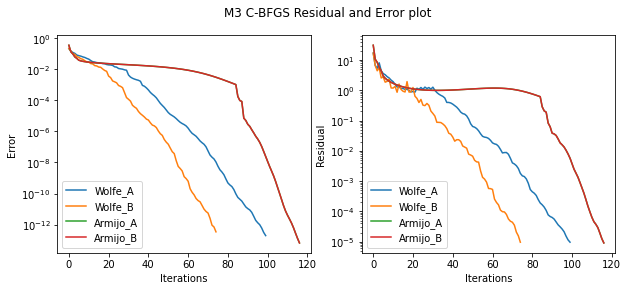

In [74]:
plot_summary(c_m3_errors_list, c_m3_residuals_list, labels_list, "M3", "C-BFGS")

#### Average runtime over 10 runs (Wolfe-type line search)

In [75]:
%%timeit -r 10
# Measuring running time
w_c_m3_bfgs_a.bfgs()

3.16 s ± 48.8 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [76]:
%%timeit -r 10
# Measuring running time
w_c_m3_bfgs_b.bfgs()

2.88 s ± 133 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


#### Average runtime over 10 runs (Armijo-type line search)

In [77]:
%%timeit -r 10
# Measuring running time
a_c_m3_bfgs_a.bfgs()

2.21 s ± 245 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [78]:
%%timeit -r 10
# Measuring running time
a_c_m3_bfgs_b.bfgs()

2.41 s ± 216 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


## M4 Matrix

### Original BFGS

In [79]:
o_m4_errors_list = []
o_m4_residuals_list = []

#### Base performance with loaded starting point (Wolfe-type line search)

In [80]:
w_o_m4_bfgs_a, w_o_m4_residuals_a, w_o_m4_errors_a = run_bfgs(M4, x0_m4, alg_method='O', ls_method='W', c1=1e-4, c2=0.9, return_arrays=True)
o_m4_errors_list.append(w_o_m4_errors_a)
o_m4_residuals_list.append(w_o_m4_residuals_a)

Convergence reached in 192 iterations
Computed Norm: 19.356959367506
True Norm: 19.356959368936618
Error: 7.390713464100296e-11


In [81]:
w_o_m4_bfgs_b, w_o_m4_residuals_b, w_o_m4_errors_b = run_bfgs(M4, x0_m4, alg_method='O', ls_method='W', c1=0.1, c2=0.49, return_arrays=True)
o_m4_errors_list.append(w_o_m4_errors_b)
o_m4_residuals_list.append(w_o_m4_residuals_b)

Convergence reached in 143 iterations
Computed Norm: 19.35695936779558
True Norm: 19.356959368936618
Error: 5.894723656372254e-11


#### Base performance with loaded starting point (Armijo-type line search)

In [82]:
a_o_m4_bfgs_a, a_o_m4_residuals_a, a_o_m4_errors_a = run_bfgs(M4, x0_m4, alg_method='O', ls_method='A', c1=1e-4, return_arrays=True)
o_m4_errors_list.append(a_o_m4_errors_a)
o_m4_residuals_list.append(a_o_m4_residuals_a)

Convergence reached in 211 iterations
Computed Norm: 19.356959366896863
True Norm: 19.356959368936618
Error: 1.0537579754493096e-10


In [83]:
a_o_m4_bfgs_b, a_o_m4_residuals_b, a_o_m4_errors_b = run_bfgs(M4, x0_m4, alg_method='O', ls_method='A', c1=0.1, return_arrays=True)
o_m4_errors_list.append(a_o_m4_errors_b)
o_m4_residuals_list.append(a_o_m4_residuals_b)

Convergence reached in 211 iterations
Computed Norm: 19.356959366896863
True Norm: 19.356959368936618
Error: 1.0537579754493096e-10


#### Summary for Original BFGS

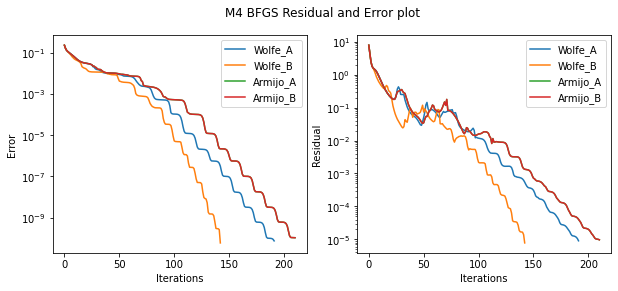

In [84]:
plot_summary(o_m4_errors_list, o_m4_residuals_list, labels_list, "M4", "BFGS")

#### Average runtime over 10 runs (Wolfe-type line search)

In [85]:
%%timeit -r 10
# Measuring running time
w_o_m4_bfgs_a.bfgs()

53.2 ms ± 2.98 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [86]:
%%timeit -r 10
# Measuring running time
w_o_m4_bfgs_b.bfgs()

45.6 ms ± 2.38 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


#### Average runtime over 10 runs (Armijo-type line search)

In [87]:
%%timeit -r 10
# Measuring running time
a_o_m4_bfgs_a.bfgs()

66.4 ms ± 10.1 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [88]:
%%timeit -r 10
# Measuring running time
a_o_m4_bfgs_b.bfgs()

70.8 ms ± 6.09 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


#### Comparison with off-shelf BFGS minimizer

In [89]:
off_shelf_opt(M4, x0_m4)
funcs = Funcs(M4)

Convergence reached in 55 iterations
Computed Norm: 18.42502728056496
True Norm: 19.356959368936618
Error: 0.048144549492994695


In [90]:
%%timeit -r 10
# Measuring running time
minimize(funcs.func_, x0_m4, method='BFGS', jac=funcs.func_grad_, options={'gtol': 1e-6, 'disp': False})

17.4 ms ± 1.51 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


##### Tests with other starting points

In [125]:
x0_m4_alt = np.round(np.random.randn(M4.shape[1]),decimals = 3)

In [126]:
off_shelf_opt(M4, x0_m4_alt)

Convergence reached in 123 iterations
Computed Norm: 19.3569593689253
True Norm: 19.356959368936618
Error: 5.847481293380535e-13


#### Comparison with off-shelf norm function

In [91]:
%%timeit -r 10
# Measuring running time
la.norm(M4, 2)

679 µs ± 22.2 µs per loop (mean ± std. dev. of 10 runs, 1000 loops each)


### Cautious BFGS

In [92]:
c_m4_errors_list = []
c_m4_residuals_list = []

#### Base performance with loaded starting point (Wolfe-type line search)

In [93]:
w_c_m4_bfgs_a, w_c_m4_residuals_a, w_c_m4_errors_a = run_bfgs(M4, x0_m4, alg_method='C', ls_method='W', c1=1e-4, c2=0.9, return_arrays=True)
c_m4_errors_list.append(w_c_m4_errors_a)
c_m4_residuals_list.append(w_c_m4_residuals_a)

Convergence reached in 58 iterations
Computed Norm: 19.356959368929605
True Norm: 19.356959368936618
Error: 3.623015716614305e-13


In [94]:
w_c_m4_bfgs_b, w_c_m4_residuals_b, w_c_m4_errors_b = run_bfgs(M4, x0_m4, alg_method='C', ls_method='W', c1=0.1, c2=0.49, return_arrays=True)
c_m4_errors_list.append(w_c_m4_errors_b)
c_m4_residuals_list.append(w_c_m4_residuals_b)

Convergence reached in 50 iterations
Computed Norm: 19.356959368930855
True Norm: 19.356959368936618
Error: 2.9769663081805486e-13


#### Base performance with loaded starting point (Armijo-type line search)

In [95]:
a_c_m4_bfgs_a, a_c_m4_residuals_a, a_c_m4_errors_a = run_bfgs(M4, x0_m4, alg_method='C', ls_method='A', c1=1e-4, return_arrays=True)
c_m4_errors_list.append(a_c_m4_errors_a)
c_m4_residuals_list.append(a_c_m4_residuals_a)

Convergence reached in 53 iterations
Computed Norm: 19.35695936893387
True Norm: 19.356959368936618
Error: 1.41873918386163e-13


In [96]:
a_c_m4_bfgs_b, a_c_m4_residuals_b, a_c_m4_errors_b = run_bfgs(M4, x0_m4, alg_method='C', ls_method='A', c1=0.1, return_arrays=True)
c_m4_errors_list.append(a_c_m4_errors_b)
c_m4_residuals_list.append(a_c_m4_residuals_b)

Convergence reached in 53 iterations
Computed Norm: 19.35695936893387
True Norm: 19.356959368936618
Error: 1.41873918386163e-13


#### Summary for Cautious BFGS

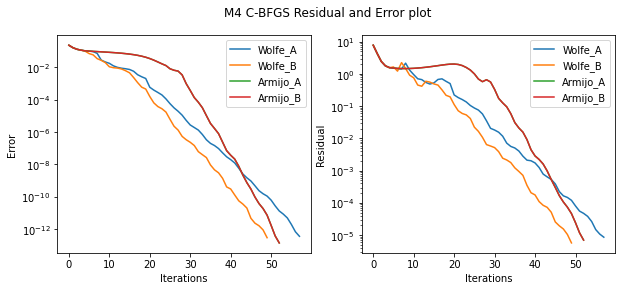

In [97]:
plot_summary(c_m4_errors_list, c_m4_residuals_list, labels_list, "M4", "C-BFGS")

#### Average runtime over 10 runs (Wolfe-type line search)

In [98]:
%%timeit -r 10
# Measuring running time
w_c_m4_bfgs_a.bfgs()

18.9 ms ± 995 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [99]:
%%timeit -r 10
# Measuring running time
w_c_m4_bfgs_b.bfgs()

20.7 ms ± 2.24 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


#### Average runtime over 10 runs (Armijo-type line search)

In [100]:
%%timeit -r 10
# Measuring running time
a_c_m4_bfgs_a.bfgs()

13.9 ms ± 1.38 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [101]:
%%timeit -r 10
# Measuring running time
a_c_m4_bfgs_b.bfgs()

13.6 ms ± 1.35 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


## M5 Matrix

### Original BFGS

In [102]:
o_m5_errors_list = []
o_m5_residuals_list = []

#### Base performance with loaded starting point (Wolfe-type line search)

In [103]:
w_o_m5_bfgs_a, w_o_m5_residuals_a, w_o_m5_errors_a = run_bfgs(M5, x0_m5, alg_method='O', ls_method='W', c1=1e-4, c2=0.9, return_arrays=True)
o_m5_errors_list.append(w_o_m5_errors_a)
o_m5_residuals_list.append(w_o_m5_residuals_a)

Convergence reached in 66 iterations
Computed Norm: 23.624892381956926
True Norm: 23.62489238197047
Error: 5.732489411855657e-13


In [104]:
w_o_m5_bfgs_b, w_o_m5_residuals_b, w_o_m5_errors_b = run_bfgs(M5, x0_m5, alg_method='O', ls_method='W', c1=0.1, c2=0.49, return_arrays=True)
o_m5_errors_list.append(w_o_m5_errors_b)
o_m5_residuals_list.append(w_o_m5_residuals_b)

Convergence reached in 52 iterations
Computed Norm: 23.624892381944633
True Norm: 23.62489238197047
Error: 1.0935640871724643e-12


#### Base performance with loaded starting point (Armijo-type line search)

In [105]:
a_o_m5_bfgs_a, a_o_m5_residuals_a, a_o_m5_errors_a = run_bfgs(M5, x0_m5, alg_method='O', ls_method='A', c1=1e-4, return_arrays=True)
o_m5_errors_list.append(a_o_m5_errors_a)
o_m5_residuals_list.append(a_o_m5_residuals_a)

Convergence reached in 66 iterations
Computed Norm: 23.624892381956926
True Norm: 23.62489238197047
Error: 5.732489411855657e-13


In [106]:
a_o_m5_bfgs_b, a_o_m5_residuals_b, a_o_m5_errors_b = run_bfgs(M5, x0_m5, alg_method='O', ls_method='A', c1=0.1, return_arrays=True)
o_m5_errors_list.append(a_o_m5_errors_b)
o_m5_residuals_list.append(a_o_m5_residuals_b)

Convergence reached in 66 iterations
Computed Norm: 23.624892381956926
True Norm: 23.62489238197047
Error: 5.732489411855657e-13


#### Summary for Original BFGS

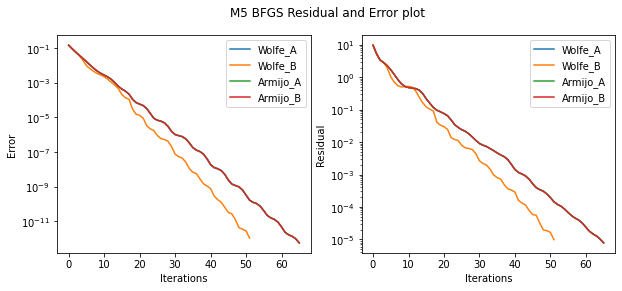

In [107]:
plot_summary(o_m5_errors_list, o_m5_residuals_list, labels_list, "M5", "BFGS")

#### Average runtime over 10 runs (Wolfe-type line search)

In [108]:
%%timeit -r 10
# Measuring running time
w_o_m5_bfgs_a.bfgs()

21.5 ms ± 1.05 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [109]:
%%timeit -r 10
# Measuring running time
w_o_m5_bfgs_b.bfgs()

18.9 ms ± 1.23 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


#### Average runtime over 10 runs (Armijo-type line search)

In [110]:
%%timeit -r 10
# Measuring running time
a_o_m5_bfgs_a.bfgs()

20.6 ms ± 1.87 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [111]:
%%timeit -r 10
# Measuring running time
a_o_m5_bfgs_b.bfgs()

23.2 ms ± 2.06 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


#### Comparison with off-shelf BFGS minimizer

In [112]:
off_shelf_opt(M5, x0_m5)
funcs = Funcs(M5)

Convergence reached in 57 iterations
Computed Norm: 23.624892381968753
True Norm: 23.62489238197047
Error: 7.263358829817111e-14


In [113]:
%%timeit -r 10
# Measuring running time
minimize(funcs.func_, x0_m5, method='BFGS', jac=funcs.func_grad_, options={'gtol': 1e-6, 'disp': False})

21.2 ms ± 2.19 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


#### Comparisonwith off-shelf norm function

In [114]:
%%timeit -r 10
# Measuring running time
la.norm(M5, 2)

4.93 ms ± 395 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


### Cautious BFGS

In [115]:
c_m5_errors_list = []
c_m5_residuals_list = []

#### Base performance with loaded starting point (Wolfe-type line search)

In [116]:
w_c_m5_bfgs_a, w_c_m5_residuals_a, w_c_m5_errors_a = run_bfgs(M5, x0_m5, alg_method='C', ls_method='W', c1=1e-4, c2=0.9, return_arrays=True)
c_m5_errors_list.append(w_c_m5_errors_a)
c_m5_residuals_list.append(w_c_m5_residuals_a)

Convergence reached in 49 iterations
Computed Norm: 23.624892381961875
True Norm: 23.62489238197047
Error: 3.6376946189084036e-13


In [117]:
w_c_m5_bfgs_b, w_c_m5_residuals_b, w_c_m5_errors_b = run_bfgs(M5, x0_m5, alg_method='C', ls_method='W', c1=0.1, c2=0.49, return_arrays=True)
c_m5_errors_list.append(w_c_m5_errors_b)
c_m5_residuals_list.append(w_c_m5_residuals_b)

Convergence reached in 40 iterations
Computed Norm: 23.62489238195983
True Norm: 23.62489238197047
Error: 4.5023801938866313e-13


#### Base performance with loaded starting point (Armijo-type line search)

In [118]:
a_c_m5_bfgs_a, a_c_m5_residuals_a, a_c_m5_errors_a = run_bfgs(M5, x0_m5, alg_method='C', ls_method='A', c1=1e-4, return_arrays=True)
c_m5_errors_list.append(a_c_m5_errors_a)
c_m5_residuals_list.append(a_c_m5_residuals_a)

Convergence reached in 55 iterations
Computed Norm: 23.624892381965143
True Norm: 23.62489238197047
Error: 2.2541976989432398e-13


In [119]:
a_c_m5_bfgs_b, a_c_m5_residuals_b, a_c_m5_errors_b = run_bfgs(M5, x0_m5, alg_method='C', ls_method='A', c1=0.1, return_arrays=True)
c_m5_errors_list.append(a_c_m5_errors_b)
c_m5_residuals_list.append(a_c_m5_residuals_b)

Convergence reached in 55 iterations
Computed Norm: 23.624892381965143
True Norm: 23.62489238197047
Error: 2.2541976989432398e-13


#### Summary for Cautious BFGS

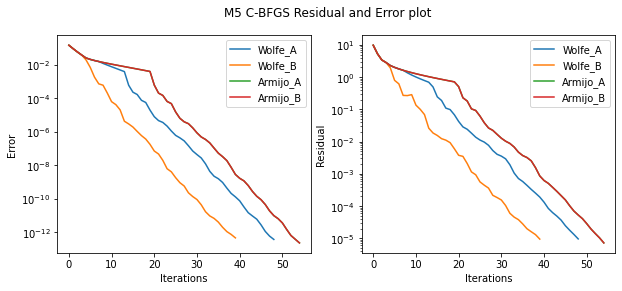

In [120]:
plot_summary(c_m5_errors_list, c_m5_residuals_list, labels_list, "M5", "C-BFGS")

#### Average runtime over 10 runs (Wolfe-type line search)

In [121]:
%%timeit -r 10
# Measuring running time
w_c_m5_bfgs_a.bfgs()

16.8 ms ± 2.85 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [122]:
%%timeit -r 10
# Measuring running time
w_c_m5_bfgs_b.bfgs()

17.5 ms ± 1.75 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


#### Average runtime over 10 runs (Armijo-type line search)

In [123]:
%%timeit -r 10
# Measuring running time
a_c_m5_bfgs_a.bfgs()

16.7 ms ± 1.47 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [124]:
%%timeit -r 10
# Measuring running time
a_c_m5_bfgs_b.bfgs()

15.6 ms ± 2.41 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)
